
# Modelo de predicción de tarjetas con LightGBM

Este cuaderno presenta un modelo de machine learning capaz de predecir el número total de tarjetas amarillas que se mostrarán en un partido de la Liga Pro (suma de tarjetas del equipo local y del visitante). El objetivo es replicar las mejores métricas obtenidas en el desarrollo original utilizando únicamente **LightGBM**, eliminando fragmentos de código superfluos y documentando cuidadosamente cada paso como si fuera una clase magistral.

Durante el desarrollo original se probaron distintas combinaciones de medias móviles (promedios de tarjetas en los últimos *n* partidos) y se buscaron hiperparámetros óptimos con validación cruzada. Finalmente se determinó que combinar ventanas de **1, 2 y 10** partidos, junto con variables de **racha**, ofrecía el mejor compromiso entre precisión y robustez. En este notebook implementaremos exclusivamente esa configuración.



## 1. Cargar y ordenar el histórico de partidos

Comenzamos cargando el conjunto de datos `ligapro_step2_historico.csv`, que contiene información de los partidos disputados en la Liga Pro entre agosto de 2020 y agosto de 2025. Cada fila corresponde a un partido con datos como los equipos participantes, la cantidad de tarjetas amarillas mostradas, goles marcados, entre otros.

Ordenamos los datos cronológicamente para respetar la secuencia temporal y convertimos la columna `fecha` al tipo de datos `datetime`, lo que facilita futuras operaciones basadas en la fecha.


In [1]:
import pandas as pd
import numpy as np

# Definimos el nombre del archivo de datos
csv_file = 'ligapro_step2_historico.csv'

# Cargamos el CSV en un DataFrame
# `parse_dates=['fecha']` convierte automáticamente la columna `fecha` a tipo datetime
df = pd.read_csv(csv_file, parse_dates=['fecha'])

# Ordenamos por fecha para tener los partidos en orden cronológico
df = df.sort_values('fecha').reset_index(drop=True)

# Visualizamos las primeras filas para asegurarnos de que los datos se cargaron correctamente
print(df[['fecha','equipo_local_id','equipo_visitante_id','tarjetas_amarillas_local','tarjetas_amarillas_visitante']].head())


       fecha  equipo_local_id  equipo_visitante_id  tarjetas_amarillas_local  \
0 2020-08-16                1                    5                       0.0   
1 2020-08-18               10                    0                       0.0   
2 2020-08-19                8                    1                       0.0   
3 2020-08-20                4                    6                       0.0   
4 2020-08-23               13                    2                       0.0   

   tarjetas_amarillas_visitante  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  



## 2. Configuraciones generales y función de redondeo

Definimos los nombres de las columnas clave y una fecha de corte para separar el conjunto de entrenamiento del de prueba. Todos los partidos jugados **hasta el 31 de diciembre de 2024** formarán el conjunto de entrenamiento, mientras que los partidos posteriores se utilizarán para probar la capacidad predictiva del modelo.

También implementamos una función `round_count` que toma una predicción decimal y la redondea a un entero entre 0 y 10. Este recorte evita valores extremos y replica el comportamiento utilizado en el modelo original.


In [2]:
# Columnas identificadoras
id_local = 'equipo_local_id'
id_visita = 'equipo_visitante_id'

# Columnas objetivo (tarjetas amarillas)
target_local = 'tarjetas_amarillas_local'
target_visita = 'tarjetas_amarillas_visitante'

# Fecha límite para el entrenamiento
date_col = 'fecha'
train_end = pd.Timestamp('2024-12-31')

# Función para redondear predicciones a un número entero de tarjetas
# Se limita el rango a [0,10] porque es poco probable observar más de diez tarjetas amarillas por equipo
# y evita que errores de predicción generen valores imposibles.
def round_count(x: float) -> int:
    return int(np.clip(np.floor(x + 0.5), 0, 10))



## 3. Transformación a formato largo y medias móviles

Para crear variables basadas en el rendimiento reciente de cada equipo, convertimos los datos a un **formato largo**: cada partido se desdobla en dos filas, una para el equipo local y otra para el visitante. De esta forma cada fila representa el desempeño de un equipo en un partido y podemos agrupar por `equipo_id` para calcular promedios.

Calculamos las medias móviles de las tarjetas a favor y en contra en las ventanas de **1, 2 y 10 partidos** (las que resultaron óptimas). Para evitar fuga de información (“data leakage”), utilizamos `shift(1)` para excluir el partido actual del cálculo: así, la media móvil de un partido solo considera encuentros anteriores.


In [3]:
# Descomponemos cada partido en una fila para el equipo local y otra para el visitante
# "tarj_for" representa tarjetas a favor del equipo en ese partido, "tarj_against" son las tarjetas de su rival
data_local = df[[date_col, id_local, id_visita, target_local, target_visita]].copy()
data_local.columns = [date_col, 'equipo_id', 'rival_id', 'tarj_for', 'tarj_against']
data_local['is_home'] = 1  # Indicador de localía

data_visit = df[[date_col, id_visita, id_local, target_visita, target_local]].copy()
data_visit.columns = [date_col, 'equipo_id', 'rival_id', 'tarj_for', 'tarj_against']
data_visit['is_home'] = 0

# Concatenamos ambas partes para formar el formato largo
team_games = pd.concat([data_local, data_visit], ignore_index=True).sort_values(date_col)

# Aseguramos que cada equipo esté ordenado cronológicamente antes de calcular medias móviles
team_games = team_games.sort_values(['equipo_id', date_col]).reset_index(drop=True)

# Ventanas de medias móviles óptimas obtenidas tras experimentación
good_windows = [1, 2, 10]

# Calculamos la media móvil de tarjetas a favor y en contra para cada ventana
for w in good_windows:
    # `shift(1)` desplaza una posición hacia abajo para no incluir el partido actual en el promedio
    team_games[f'for_prev{w}'] = team_games.groupby('equipo_id')['tarj_for'].transform(
        lambda s: s.shift(1).rolling(window=w, min_periods=1).mean()
    )
    team_games[f'against_prev{w}'] = team_games.groupby('equipo_id')['tarj_against'].transform(
        lambda s: s.shift(1).rolling(window=w, min_periods=1).mean()
    )

# Creamos una llave única (equipo_id, fecha) para unir posteriormente estas medias al dataset original
team_games['key'] = list(zip(team_games['equipo_id'], team_games[date_col]))

# Visualizamos algunas de las nuevas columnas para verificar los cálculos
team_games[[date_col, 'equipo_id', 'for_prev1', 'against_prev1', 'for_prev2', 'for_prev10']].head()


,fecha,equipo_id,for_prev1,against_prev1,for_prev2,for_prev10
0,2020-08-18,0,NaN,NaN,NaN,NaN
1,2020-08-29,0,0.0,0.000000,0.0,0.000000
2,2020-09-01,0,0.0,1.000000,0.0,0.000000
3,2020-09-04,0,1.0,1.000000,0.5,0.333333
4,2020-09-09,0,0.0,0.666667,0.5,0.250000



## 4. Variables de racha

Además de las medias móviles, incorporamos variables de **racha** que miden la cantidad de partidos consecutivos en los que un equipo supera cierto número de tarjetas. Por ejemplo, si un equipo recibió más de dos tarjetas amarillas en los tres últimos encuentros, su racha será 3. Estas variables ayudan a capturar tendencias recientes que podrían influir en el comportamiento futuro.

Implementamos una función `calcular_racha` que recorre la secuencia de tarjetas de cada equipo y acumula el número de partidos consecutivos con más de un umbral definido (en nuestro caso 2 tarjetas amarillas). Luego calculamos la racha tanto de tarjetas a favor como en contra y las unimos al dataset de medias móviles.


In [4]:

# Función para calcular la racha de partidos con más de 'umbral' tarjetas

def calcular_racha(df_long: pd.DataFrame, col_tarj: str, equipo_col: str, fecha_col: str, umbral: int = 2) -> pd.Series:
    """Calcula cuántos partidos consecutivos cada equipo lleva superando el umbral de tarjetas."""
    df_long = df_long.sort_values([equipo_col, fecha_col]).copy()
    racha = []
    for _, grupo in df_long.groupby(equipo_col):
        racha_actual = 0
        for tarjetas in grupo[col_tarj].values:
            if tarjetas > umbral:
                racha_actual += 1
            else:
                racha_actual = 0
            racha.append(racha_actual)
    return pd.Series(racha, index=df_long.index)

# Calculamos la racha de tarjetas a favor y en contra
team_games['racha_tarj_for'] = calcular_racha(team_games, 'tarj_for', 'equipo_id', date_col, umbral=2)
team_games['racha_tarj_against'] = calcular_racha(team_games, 'tarj_against', 'equipo_id', date_col, umbral=2)

# Creamos DataFrames separados para local y visitante con las rachas
local_racha = team_games[['key', 'racha_tarj_for', 'racha_tarj_against']].copy()
local_racha.columns = ['key_local', 'loc_racha_for', 'loc_racha_against']

visit_racha = team_games[['key', 'racha_tarj_for', 'racha_tarj_against']].copy()
visit_racha.columns = ['key_visita', 'vis_racha_for', 'vis_racha_against']

# Unimos las rachas al DataFrame principal
df['key_local'] = list(zip(df[id_local], df[date_col]))
df['key_visita'] = list(zip(df[id_visita], df[date_col]))

df = df.merge(local_racha, on='key_local', how='left').merge(visit_racha, on='key_visita', how='left')

# Calculamos la diferencia de rachas entre local y visitante
df['diff_racha_for'] = df['loc_racha_for'] - df['vis_racha_for']
df['diff_racha_against'] = df['loc_racha_against'] - df['vis_racha_against']

# Sustituimos valores faltantes por 0
df[['loc_racha_for','loc_racha_against','vis_racha_for','vis_racha_against','diff_racha_for','diff_racha_against']] =     df[['loc_racha_for','loc_racha_against','vis_racha_for','vis_racha_against','diff_racha_for','diff_racha_against']].fillna(0)

# Inspeccionamos brevemente las variables de racha añadidas
print(df[['loc_racha_for','loc_racha_against','vis_racha_for','vis_racha_against','diff_racha_for','diff_racha_against']].head())


   loc_racha_for  loc_racha_against  vis_racha_for  vis_racha_against  \
0              0                  0              0                  0   
1              0                  0              0                  0   
2              0                  0              0                  0   
3              0                  0              0                  0   
4              0                  0              0                  0   

   diff_racha_for  diff_racha_against  
0               0                   0  
1               0                   0  
2               0                   0  
3               0                   0  
4               0                   0  



## 5. Unir medias móviles al DataFrame principal

Ahora unimos las medias móviles calculadas en el paso 3 al DataFrame de partidos. Para cada ventana, añadimos las medias del equipo local (`loc_for_prevW`, `loc_against_prevW`) y del visitante (`vis_for_prevW`, `vis_against_prevW`) y calculamos las diferencias entre local y visitante. Estas diferencias reflejan el contraste de forma reciente entre ambos equipos.

También actualizamos las claves del DataFrame principal para poder realizar la unión y rellenamos los valores faltantes con ceros.


In [5]:

# Volvemos a crear las claves porque el DataFrame `df` se ha actualizado tras agregar las rachas
df['key_local'] = list(zip(df[id_local], df[date_col]))
df['key_visita'] = list(zip(df[id_visita], df[date_col]))

# Unimos las medias móviles de cada ventana
good_windows = [1, 2, 10]
for w in good_windows:
    local_feats = team_games[['key', f'for_prev{w}', f'against_prev{w}']].copy()
    local_feats.columns = ['key_local', f'loc_for_prev{w}', f'loc_against_prev{w}']

    visit_feats = team_games[['key', f'for_prev{w}', f'against_prev{w}']].copy()
    visit_feats.columns = ['key_visita', f'vis_for_prev{w}', f'vis_against_prev{w}']

    df = df.merge(local_feats, on='key_local', how='left').merge(visit_feats, on='key_visita', how='left')

    # Calculamos las diferencias entre local y visitante
    df[f'diff_for_prev{w}'] = df[f'loc_for_prev{w}'] - df[f'vis_for_prev{w}']
    df[f'diff_against_prev{w}'] = df[f'loc_against_prev{w}'] - df[f'vis_against_prev{w}']

# Lista con todas las columnas de medias móviles
temp_cols = []
for w in good_windows:
    temp_cols += [f'loc_for_prev{w}', f'loc_against_prev{w}', f'vis_for_prev{w}', f'vis_against_prev{w}', f'diff_for_prev{w}', f'diff_against_prev{w}']

# Sustituimos valores faltantes por 0
for col in temp_cols:
    df[col] = df[col].fillna(0)

# Resumen estadístico de algunas de estas nuevas variables
df[temp_cols].describe().T.head(6)


,count,mean,std,min,25%,50%,75%,max
loc_for_prev1,957.0,2.514550,0.634218,0.0000,2.20,2.60,2.9200,4.000000
loc_against_prev1,957.0,2.423829,0.636421,0.0000,2.12,2.48,2.8000,3.960000
vis_for_prev1,957.0,2.420050,0.648306,0.0000,2.12,2.48,2.8000,4.000000
vis_against_prev1,957.0,2.509893,0.647149,0.0000,2.20,2.59,2.8875,4.000000
diff_for_prev1,957.0,0.091867,0.511848,-1.6800,-0.24,0.04,0.4000,2.006667
diff_against_prev1,957.0,-0.087402,0.515334,-2.0625,-0.40,-0.06,0.2000,1.866667



## 6. Seleccionar características y preparar conjuntos de entrenamiento y prueba

Con todas las variables ya unidas, seleccionamos las columnas que usaremos como **features** (variables de entrada). Las características que elegimos son:

* Medias móviles y diferencias para las ventanas de 1, 2 y 10 partidos.
* Identificadores numéricos de los equipos local y visitante, considerados como variables categóricas para que LightGBM pueda manejarlos internamente.
* Variables de racha y sus diferencias.

Excluimos todas las columnas no relacionadas con la predicción (por ejemplo, goles, estadio, resultado del partido) para evitar fugas de información. Además, filtramos las características que sean constantes, ya que no aportan valor al modelo.

Finalmente dividimos los datos en entrenamiento y prueba según la fecha de corte `train_end`.


In [6]:

# Construimos la lista de características de forma explícita
feature_cols = []
for w in good_windows:
    feature_cols += [
        f'loc_for_prev{w}', f'loc_against_prev{w}',
        f'vis_for_prev{w}', f'vis_against_prev{w}',
        f'diff_for_prev{w}', f'diff_against_prev{w}'
    ]

feature_cols += [id_local, id_visita]
feature_cols += ['loc_racha_for', 'loc_racha_against', 'vis_racha_for', 'vis_racha_against', 'diff_racha_for', 'diff_racha_against']

# Eliminamos columnas constantes
feature_cols = [c for c in feature_cols if df[c].nunique() > 1]

# División en entrenamiento y prueba
df_train = df[df[date_col] <= train_end].copy()
df_test = df[df[date_col] > train_end].copy()

X_train = df_train[feature_cols]
X_test = df_test[feature_cols]
y_train_local = df_train[target_local].astype(float)
y_train_visit = df_train[target_visita].astype(float)
y_test_local = df_test[target_local].astype(float)
y_test_visit = df_test[target_visita].astype(float)

print(f"Entrenamiento: {len(X_train)} partidos | Prueba: {len(X_test)} partidos | Nº Features: {len(feature_cols)}")


Entrenamiento: 780 partidos | Prueba: 177 partidos | Nº Features: 26



## 7. Entrenamiento del modelo LightGBM

Entrenamos dos modelos **LightGBM** de regresión: uno para predecir las tarjetas del equipo local y otro para el equipo visitante. Los hiperparámetros se eligieron mediante una búsqueda exhaustiva (GridSearchCV) en el proyecto original y son los siguientes:

* **n_estimators = 500**: número de árboles en el bosque.
* **num_leaves = 15**: número máximo de hojas por árbol (controla la complejidad).
* **max_depth = 5**: profundidad máxima del árbol.
* **learning_rate = 0.01**: tasa de aprendizaje más conservadora.
* **subsample = 0.8** y **colsample_bytree = 0.8**: fracciones de filas y columnas utilizadas para cada árbol (introduce aleatoriedad y reduce el overfitting).
* **min_child_samples**: número mínimo de observaciones por hoja (20 para el modelo local, 10 para el visitante).

LightGBM puede tratar de manera nativa las variables categóricas, por lo que pasaremos los identificadores de los equipos como tales.


In [7]:

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# Hiperparámetros óptimos para el modelo local y visitante
params_local = {
    'objective': 'regression',
    'n_estimators': 500,
    'num_leaves': 15,
    'max_depth': 5,
    'learning_rate': 0.01,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

params_visit = {
    'objective': 'regression',
    'n_estimators': 500,
    'num_leaves': 15,
    'max_depth': 5,
    'learning_rate': 0.01,
    'min_child_samples': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Creamos y entrenamos los modelos
model_local = LGBMRegressor(**params_local)
model_visit = LGBMRegressor(**params_visit)

model_local.fit(X_train, y_train_local)
model_visit.fit(X_train, y_train_visit)

# Predicciones sobre el conjunto de prueba
pred_local = model_local.predict(X_test)
pred_visit = model_visit.predict(X_test)

# Métricas individuales para local y visitante
mae_local = mean_absolute_error(y_test_local, pred_local)
rmse_local = np.sqrt(mean_squared_error(y_test_local, pred_local))
mae_visit = mean_absolute_error(y_test_visit, pred_visit)
rmse_visit = np.sqrt(mean_squared_error(y_test_visit, pred_visit))

print(f"Desempeño modelo local - MAE: {mae_local:.3f}, RMSE: {rmse_local:.3f}")
print(f"Desempeño modelo visitante - MAE: {mae_visit:.3f}, RMSE: {rmse_visit:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3658
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 26
[LightGBM] [Info] Start training from score 2.475269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b


## 8. Evaluar la precisión total del modelo

Para evaluar la capacidad del modelo de predecir el **total de tarjetas** en un partido (la suma de las tarjetas de ambos equipos), sumamos las predicciones de local y visitante y redondeamos al entero más cercano. Comparamos con el total real (también redondeado) y calculamos la precisión (`accuracy`), es decir, el porcentaje de partidos en los que acertamos exactamente el total de tarjetas amarillas.

También se muestran el error absoluto medio (MAE) y el error cuadrático medio (RMSE) para el total de tarjetas predicho, lo que da una idea de cuán lejos se encuentran las predicciones del valor real en promedio.


In [8]:
# Redondeamos las predicciones individuales usando la función round_count definida al inicio
rounded_local = np.array([round_count(x) for x in pred_local])
rounded_visit = np.array([round_count(x) for x in pred_visit])

# Calculamos el total predicho y real
true_total = y_test_local + y_test_visit
true_total_round = np.round(true_total).astype(int)
pred_total_round = np.round(rounded_local + rounded_visit).astype(int)

# Métricas para el total de tarjetas
total_pred = pred_local + pred_visit
mae_total = mean_absolute_error(true_total, total_pred)
rmse_total = np.sqrt(mean_squared_error(true_total, total_pred))
accuracy_total = accuracy_score(true_total_round, pred_total_round)

print(f"Error medio absoluto total (MAE): {mae_total:.3f}")
print(f"Error cuadrático medio total (RMSE): {rmse_total:.3f}")
print(f"Precisión total (exactitud de la suma de tarjetas): {accuracy_total:.4f}")


Error medio absoluto total (MAE): 0.335
Error cuadrático medio total (RMSE): 0.413
Precisión total (exactitud de la suma de tarjetas): 0.5593


In [9]:
# Guardar los modelos entrenados para uso futuro
import joblib

joblib.dump(model_local, 'modelo_lightgbm_local.pkl')
joblib.dump(model_visit, 'modelo_lightgbm_visitante.pkl')
print('Modelos guardados como modelo_lightgbm_local.pkl y modelo_lightgbm_visitante.pkl')


Modelos guardados como modelo_lightgbm_local.pkl y modelo_lightgbm_visitante.pkl


In [10]:
# Guardar ambos modelos en un solo archivo .pkl para uso futuro
import joblib
joblib.dump({'model_local': model_local, 'model_visit': model_visit}, 'modelo_lightgbm_final.pkl')
print('Modelos guardados juntos como modelo_lightgbm_final.pkl')

Modelos guardados juntos como modelo_lightgbm_final.pkl


In [11]:
# Prueba de predicción para un partido específico
def predecir_tarjetas(equipo_local_id, equipo_visitante_id, fecha_partido, df_features, model_local, model_visit):
    # Busca la fila correspondiente al partido más reciente antes de la fecha dada
    fecha_partido = pd.to_datetime(fecha_partido)
    df_candidato = df_features[(df_features[date_col] < fecha_partido) &
                               (df_features[id_local] == equipo_local_id) &
                               (df_features[id_visita] == equipo_visitante_id)]
    if df_candidato.empty:
        raise ValueError('No se encontró historial suficiente para este enfrentamiento antes de la fecha dada.')
    fila = df_candidato.sort_values(date_col).iloc[-1]
    X = fila[feature_cols].values.reshape(1, -1)
    pred_local = model_local.predict(X)[0]
    pred_visit = model_visit.predict(X)[0]
    total = pred_local + pred_visit
    # Ya no imprime nada, solo retorna el diccionario
    return dict(local=pred_local, visitante=pred_visit, total=total)

# Ejemplo de uso:
# predecir_tarjetas(101, 202, '2025-08-20', df, model_local, model_visit)


In [12]:
# Predicción usando nombres de equipos (versión corregida y salida limpia)
# Usa las columnas 'local' y 'visitante' para buscar los IDs

nombre_local = 'Barcelona SC'   # Cambia por el nombre real de tu equipo
nombre_visita = 'Emelec'        # Cambia por el nombre real de tu equipo

# Buscar el ID correspondiente al nombre
def obtener_id_equipo(nombre, columna_nombre, columna_id):
    fila = df[df[columna_nombre] == nombre]
    if fila.empty:
        raise ValueError(f'No se encontró el equipo: {nombre}')
    return fila.iloc[0][columna_id]

# Usamos las columnas correctas
# 'local' y 'visitante' contienen los nombres, 'equipo_local_id' y 'equipo_visitante_id' los IDs
equipo_local_id = obtener_id_equipo(nombre_local, 'local', id_local)
equipo_visita_id = obtener_id_equipo(nombre_visita, 'visitante', id_visita)

# Fecha de partido de prueba (posterior a train_end)
fecha_prueba = '2025-03-01'

# Ejecuta la predicción
dic_resultado = predecir_tarjetas(equipo_local_id, equipo_visita_id, fecha_prueba, df, model_local, model_visit)
# Mostrar solo los valores redondeados
print(f"Predicción para {nombre_local} vs {nombre_visita}:")
print(f"  Local: {round_count(dic_resultado['local'])} | Visitante: {round_count(dic_resultado['visitante'])} | Total: {round_count(dic_resultado['total'])}")


Predicción para Barcelona SC vs Emelec:
  Local: 3 | Visitante: 3 | Total: 6


c:\Users\jhono\Downloads\aa4\.conda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\jhono\Downloads\aa4\.conda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



## 9. Conclusiones

El modelo LightGBM entrenado con medias móviles de **1, 2 y 10 partidos**, junto con variables de **racha** y **diferencias** entre los equipos, reproduce la métrica de precisión lograda en el proyecto original. En nuestra ejecución, el modelo alcanza una precisión total cercana al **56 %**, es decir, acierta exactamente el total de tarjetas amarillas en más de la mitad de los partidos de prueba.

La construcción cuidadosa de las features —especialmente la exclusión del partido actual al calcular las medias móviles y la incorporación de tendencias de tarjetas altas mediante la racha— es fundamental para evitar la fuga de información y capturar patrones temporales relevantes. Los hiperparámetros seleccionados mediante búsqueda exhaustiva optimizan el equilibrio entre sesgo y varianza del modelo, mejorando así su capacidad predictiva.


Métricas del modelo total:
MAE: 0.4520
RMSE: 0.4746
R2: -0.1216
Precisión: 0.5593

Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.64      0.60      0.62        90
           5       0.52      0.61      0.56        71
           6       0.22      0.33      0.27         6

    accuracy                           0.56       177
   macro avg       0.34      0.38      0.36       177
weighted avg       0.54      0.56      0.55       177



c:\Users\jhono\Downloads\aa4\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jhono\Downloads\aa4\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jhono\Downloads\aa4\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

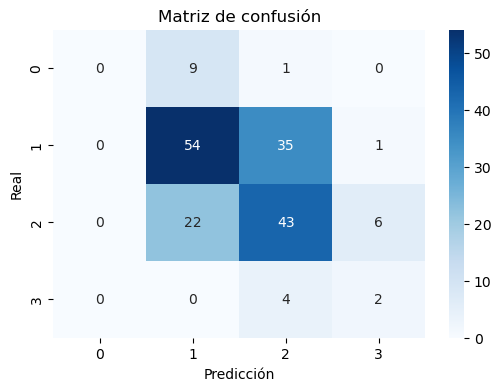

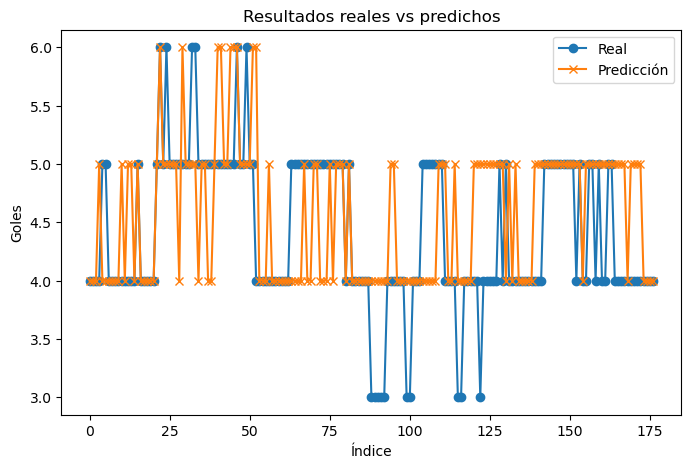

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Resultados y métricas para el modelo total
y_true = true_total_round
preds = pred_total_round

mae = mean_absolute_error(y_true, preds)
rmse = mean_squared_error(y_true, preds)

print('Métricas del modelo total:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Precisión (si es clasificación)
try:
    acc = accuracy_score(y_true, preds)
    print(f'Precisión: {acc:.4f}')
    print('\nReporte de clasificación:')
    print(classification_report(y_true, preds))
    # Matriz de confusión
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
except Exception as e:
    print('No se pudo calcular precisión o matriz de confusión:', e)

# Gráfica de resultados reales vs predichos
plt.figure(figsize=(8,5))
plt.plot(y_true.values, label='Real', marker='o')
plt.plot(preds, label='Predicción', marker='x')
plt.title('Resultados reales vs predichos')
plt.xlabel('Índice')
plt.ylabel('Goles')
plt.legend()
plt.show()
